<a href="https://colab.research.google.com/github/kridtapon/Momentum-Driven-Volume-Breakout-MDVB-/blob/main/Momentum_Driven_Volume_Breakout_(MDVB).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.8/527.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.8 MB/s eta 0:00:00


In [2]:
pip install --upgrade yfinance

In [25]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# === Define the stock symbol and time period ===
symbol = 'TRGP'
start_date = '2019-01-01'
end_date = '2025-01-01'

# === Download data ===
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# === Calculate MACD (12,26,9) ===
ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# === Calculate ADX (14) ===
high = df['High']
low = df['Low']
close = df['Close']

plus_dm = high.diff()
minus_dm = low.diff()
plus_dm[plus_dm < 0] = 0
minus_dm[minus_dm > 0] = 0
tr1 = high - low
tr2 = abs(high - close.shift())
tr3 = abs(low - close.shift())
tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

atr = tr.rolling(window=14).mean()
plus_di = 100 * (plus_dm.rolling(window=14).mean() / atr)
minus_di = abs(100 * (minus_dm.rolling(window=14).mean() / atr))
dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
df['ADX'] = dx.rolling(window=14).mean()

# === 50-day Simple Moving Average ===
df['SMA50'] = df['Close'].rolling(window=50).mean()

# === Filter for test period ===
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# === Entry Signal ===
df['Entry'] = (
    (df['MACD'] > df['MACD_Signal']) &
    (df['MACD'].shift(1) <= df['MACD_Signal'].shift(1)) &  # Crossover confirmation
    (df['MACD'] > 0) &
    (df['ADX'] > 20) &
    (df['Close'] > df['SMA50'])
)

# === Exit Signal ===
df['Exit'] = (
    (df['MACD'] < df['MACD_Signal']) &
    (df['MACD'].shift(1) >= df['MACD_Signal'].shift(1)) &
    (df['MACD'] < 0) &
    (df['Close'] < df['SMA50'])
)

# === Shift entries/exits to simulate execution at next open ===
shifted_entries = df['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
shifted_exits = df['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

# === Create Portfolio ===
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],  # Use Open for execution
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# === Display Results ===
print(portfolio.stats())
portfolio.plot().show()


/tmp/ipython-input-25-2201174291.py:12: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           824020.822505
Total Return [%]                       724.020823
Benchmark Return [%]                   391.323483
Max Gross Exposure [%]                      100.0
Total Fees Paid                        1348.82466
Max Drawdown [%]                        29.308231
Max Drawdown Duration           458 days 00:00:00
Total Trades                                    3
Total Closed Trades                             2
Total Open Trades                               1
Open Trade PnL                      443524.916813
Win Rate [%]                                100.0
Best Trade [%]                         144.109716
Worst Trade [%]                           56.0188
Avg Winning Trade [%]                  100.064258
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-27-4064494669.py:14: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-27-4064494669.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-27-4064494669.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-27-4064494669.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

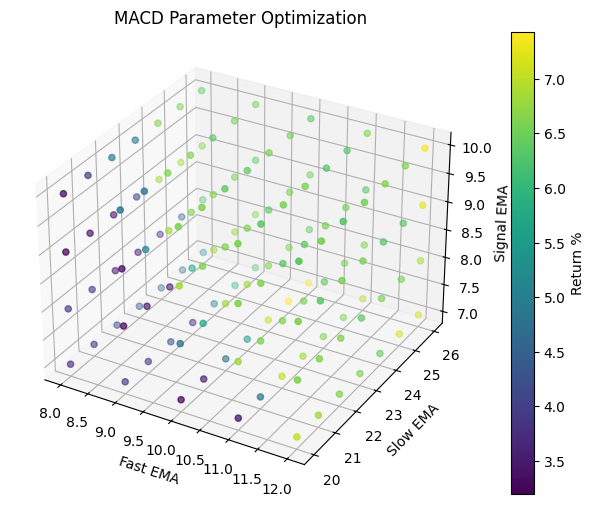

Best MACD Parameters: Fast = 10.0, Slow = 25.0, Signal = 7.0, Return = 7.43


/tmp/ipython-input-27-4064494669.py:125: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-27-4064494669.py:132: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-27-4064494669.py:125: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ip

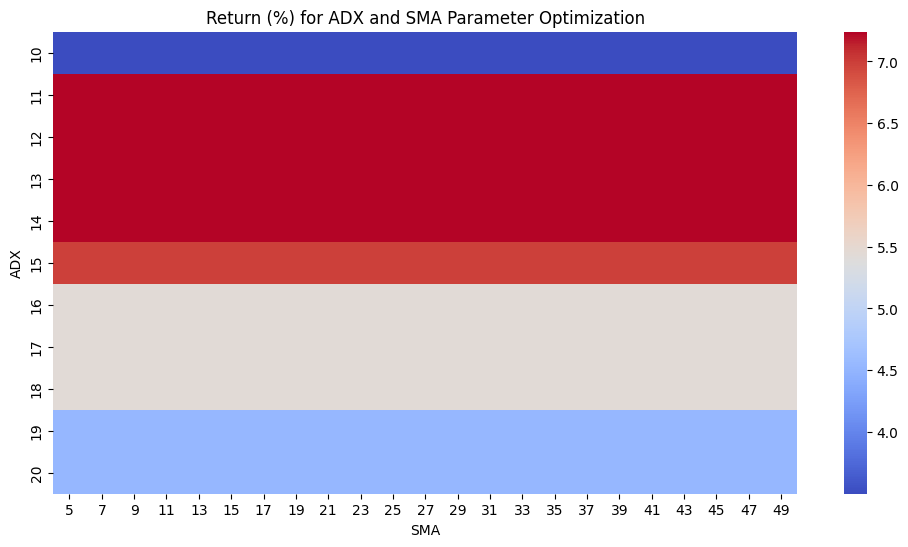

Best ADX and SMA Parameters: ADX = 11.0, SMA = 5.0, Return = 7.24


In [27]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# === Download Data ===
symbol = 'TRGP'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# === Define MACD Parameter Ranges ===
fast_range = range(8, 13)
slow_range = range(20, 27)
signal_range = range(7, 11)

results_macd = []

for fast, slow, signal in itertools.product(fast_range, slow_range, signal_range):
    if fast >= slow:
        continue

    df_temp = df.copy()
    macd = df_temp['Close'].ewm(span=fast, adjust=False).mean() - df_temp['Close'].ewm(span=slow, adjust=False).mean()
    signal_line = macd.ewm(span=signal, adjust=False).mean()

    # ADX
    high, low, close = df_temp['High'], df_temp['Low'], df_temp['Close']
    plus_dm = high.diff().clip(lower=0)
    minus_dm = -low.diff().clip(upper=0)
    tr = pd.concat([high - low, abs(high - close.shift()), abs(low - close.shift())], axis=1).max(axis=1)
    atr = tr.rolling(window=14).mean()
    plus_di = 100 * (plus_dm.rolling(window=14).mean() / atr)
    minus_di = 100 * (minus_dm.rolling(window=14).mean() / atr)
    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = dx.rolling(window=14).mean()

    df_temp['MACD'] = macd
    df_temp['MACD_Signal'] = signal_line
    df_temp['ADX'] = adx
    df_temp['SMA50'] = df_temp['Close'].rolling(window=50).mean()

    df_test = df_temp[(df_temp.index.year >= 2020) & (df_temp.index.year <= 2025)]

    df_test['Entry'] = (
        (df_test['MACD'] > df_test['MACD_Signal']) &
        (df_test['MACD'].shift(1) <= df_test['MACD_Signal'].shift(1)) &
        (df_test['MACD'] > 0) &
        (df_test['ADX'] > 20) &
        (df_test['Close'] > df_test['SMA50'])
    )
    df_test['Exit'] = (
        (df_test['MACD'] < df_test['MACD_Signal']) &
        (df_test['MACD'].shift(1) >= df_test['MACD_Signal'].shift(1)) &
        (df_test['MACD'] < 0) &
        (df_test['Close'] < df_test['SMA50'])
    )

    entries = df_test['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
    exits = df_test['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

    pf = vbt.Portfolio.from_signals(
        close=df_test['Open'],
        entries=entries,
        exits=exits,
        init_cash=100_000,
        fees=0.001,
        slippage=0.002,
        freq='D'
    )

    results_macd.append((fast, slow, signal, pf.total_return()))

# === Convert to DataFrame and Plot ===
df_macd = pd.DataFrame(results_macd, columns=['Fast', 'Slow', 'Signal', 'Return'])

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df_macd['Fast'], df_macd['Slow'], df_macd['Signal'], c=df_macd['Return'], cmap='viridis')
ax.set_xlabel('Fast EMA')
ax.set_ylabel('Slow EMA')
ax.set_zlabel('Signal EMA')
fig.colorbar(sc, label='Return %')
plt.title('MACD Parameter Optimization')
plt.show()

# === Print best MACD parameters ===
best_macd = df_macd.loc[df_macd['Return'].idxmax()]
print(f"Best MACD Parameters: Fast = {best_macd['Fast']}, Slow = {best_macd['Slow']}, Signal = {best_macd['Signal']}, Return = {best_macd['Return']:.2f}")

adx_periods = range(10, 21)
sma_periods = range(5, 50, 2)

results_adx_sma = []

for adx_p, sma_p in itertools.product(adx_periods, sma_periods):
    df_temp = df.copy()

    # MACD fixed
    macd = df_temp['Close'].ewm(span=12, adjust=False).mean() - df_temp['Close'].ewm(span=26, adjust=False).mean()
    signal_line = macd.ewm(span=9, adjust=False).mean()

    # ADX
    high, low, close = df_temp['High'], df_temp['Low'], df_temp['Close']
    plus_dm = high.diff().clip(lower=0)
    minus_dm = -low.diff().clip(upper=0)
    tr = pd.concat([high - low, abs(high - close.shift()), abs(low - close.shift())], axis=1).max(axis=1)
    atr = tr.rolling(window=adx_p).mean()
    plus_di = 100 * (plus_dm.rolling(window=adx_p).mean() / atr)
    minus_di = 100 * (minus_dm.rolling(window=adx_p).mean() / atr)
    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = dx.rolling(window=adx_p).mean()

    df_temp['MACD'] = macd
    df_temp['MACD_Signal'] = signal_line
    df_temp['ADX'] = adx
    df_temp['SMA'] = df_temp['Close'].rolling(window=sma_p).mean()

    df_test = df_temp[(df_temp.index.year >= 2020) & (df_temp.index.year <= 2025)]

    df_test['Entry'] = (
        (df_test['MACD'] > df_test['MACD_Signal']) &
        (df_test['MACD'].shift(1) <= df_test['MACD_Signal'].shift(1)) &
        (df_test['MACD'] > 0) &
        (df_test['ADX'] > 20) &
        (df_test['Close'] > df_test['SMA'])
    )
    df_test['Exit'] = (
        (df_test['MACD'] < df_test['MACD_Signal']) &
        (df_test['MACD'].shift(1) >= df_test['MACD_Signal'].shift(1)) &
        (df_test['MACD'] < 0) &
        (df_test['Close'] < df_test['SMA'])
    )

    entries = df_test['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
    exits = df_test['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

    pf = vbt.Portfolio.from_signals(
        close=df_test['Open'],
        entries=entries,
        exits=exits,
        init_cash=100_000,
        fees=0.001,
        slippage=0.002,
        freq='D'
    )

    results_adx_sma.append((adx_p, sma_p, pf.total_return()))

# Create heatmap
df_heatmap = pd.DataFrame(results_adx_sma, columns=['ADX', 'SMA', 'Return'])
heatmap_data = df_heatmap.pivot(index='ADX', columns='SMA', values='Return')

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=False, fmt=".1f", cmap="coolwarm")
plt.title('Return (%) for ADX and SMA Parameter Optimization')
plt.show()

# === Print best ADX and SMA parameters ===
best_adx_sma = df_heatmap.loc[df_heatmap['Return'].idxmax()]
print(f"Best ADX and SMA Parameters: ADX = {best_adx_sma['ADX']}, SMA = {best_adx_sma['SMA']}, Return = {best_adx_sma['Return']:.2f}")


In [28]:
# === Calculate MACD ===
ema12 = df['Close'].ewm(span=10, adjust=False).mean()
ema26 = df['Close'].ewm(span=25, adjust=False).mean()
df['MACD'] = ema12 - ema26
df['MACD_Signal'] = df['MACD'].ewm(span=7, adjust=False).mean()

# === Calculate ADX ===
high = df['High']
low = df['Low']
close = df['Close']

plus_dm = high.diff()
minus_dm = low.diff()
plus_dm[plus_dm < 0] = 0
minus_dm[minus_dm > 0] = 0
tr1 = high - low
tr2 = abs(high - close.shift())
tr3 = abs(low - close.shift())
tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

atr = tr.rolling(window=11).mean()
plus_di = 100 * (plus_dm.rolling(window=11).mean() / atr)
minus_di = abs(100 * (minus_dm.rolling(window=11).mean() / atr))
dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
df['ADX'] = dx.rolling(window=11).mean()

# === Simple Moving Average ===
df['SMA5'] = df['Close'].rolling(window=5).mean()

# === Filter for test period ===
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# === Entry Signal ===
df['Entry'] = (
    (df['MACD'] > df['MACD_Signal']) &
    (df['MACD'].shift(1) <= df['MACD_Signal'].shift(1)) &  # Crossover confirmation
    (df['MACD'] > 0) &
    (df['ADX'] > 20) &
    (df['Close'] > df['SMA5'])
)

# === Exit Signal ===
df['Exit'] = (
    (df['MACD'] < df['MACD_Signal']) &
    (df['MACD'].shift(1) >= df['MACD_Signal'].shift(1)) &
    (df['MACD'] < 0) &
    (df['Close'] < df['SMA5'])
)

# === Shift entries/exits to simulate execution at next open ===
shifted_entries = df['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
shifted_exits = df['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

# === Create Portfolio ===
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],  # Use Open for execution
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# === Display Results ===
print(portfolio.stats())
portfolio.plot().show()

/tmp/ipython-input-28-2659438070.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-28-2659438070.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           966970.995194
Total Return [%]                       866.970995
Benchmark Return [%]                   391.323483
Max Gross Exposure [%]                      100.0
Total Fees Paid                       1359.759305
Max Drawdown [%]                        29.308231
Max Drawdown Duration           325 days 00:00:00
Total Trades                                    3
Total Closed Trades                             2
Total Open Trades                               1
Open Trade PnL                      589777.152725
Win Rate [%]                                100.0
Best Trade [%]                         152.887865
Worst Trade [%]                         49.293967
Avg Winning Trade [%]                  101.090916
Avg Losing Trade [%]                          NaN
